# Re-entrenamiento del modelo

Re-entrenamos el modelo SSD con el conjunto de datos de imágenes de *ballenas*. El código esta basado en la implementación con Keras del modelo de entrenamiento original de SSD300 "07+12" en los datasets de Pascal VOC (https://github.com/pierluigiferrari/ssd_keras).

In [1]:
# usando gpu 1
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.
/home/aalejo/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aalejo/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aalejo/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aalejo/anaconda3/envs/dl/l

## Parámetros de configuración

In [3]:
img_height = 512 # Alto de las imágenes de entrada del modelo
img_width = 512 # Ancho de las imágenes de entrada del modelo
img_channels = 3 # Número de canales de color de las imágenes de entrada del modelo
mean_color = [123, 117, 104]
swap_channels = [2, 1, 0]

#n_classes = 20
n_classes = 1 # Nro. de clases positivas, 1 sola (ballenas)

scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # factores de escala del cuadro de anclaje
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
scales = scales_pascal

aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # Las proporciones del cuadro

two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300]
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes = False
variances = [0.1, 0.1, 0.2, 0.2]
normalize_coords = True

## Construcción del modelo

Llamamos a la función ssd_300() para construir el modelo, cargamos los pesos de VGG-16, utilizamos el optimizador Adam y finalmente compilamos.

In [4]:
K.clear_session()

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# Cargando los pesos de VGG-16
weights_path = '../ssd_keras/VGG_ILSVRC_16_layers_fc_reduced.h5'
model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


## Generador de datos

Aqui es donde definimos las rutas de archivos del conjunto de datos de ballenas, las anotaciones XML, y la lista de nombres de las imágenes, creadas en el notebook [xml_annotations.ipynb](xml_annotations.ipynb).

Cargamos el dataset completo en memoria reduciendo el tiempo de acceso a cada imagen considerablemente.

In [7]:
!pip install lxml

In [10]:
# Instanciando 2 objetos `DataGenerator`: Uno para entrenamiento y otro para validación.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# Revisamos las anotaciones XML

whales_images_dir_trainval = '../ssd_keras/datasets/whales/train/train/' # JPGs
whales_annotations_dir = '../ssd_keras/datasets/whales/annotations/' # XMLs
whales_train_image_set_filename = '../ssd_keras/datasets/whales/train.txt' # nombres por linea sin extension
whales_val_image_set_filename = '../ssd_keras/datasets/whales/val.txt' # nombres por linea sin extension

classes = ['background','whale']

train_dataset.parse_xml(images_dirs=[whales_images_dir_trainval],
                        image_set_filenames=[whales_train_image_set_filename],
                        annotations_dirs=[whales_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[whales_images_dir_trainval],
                      image_set_filenames=[whales_val_image_set_filename],
                      annotations_dirs=[whales_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)


Loading images into memory: 100%|██████████| 200/200 [00:00<00:00, 223.80it/s]


In [12]:
batch_size = 32

# Transformación e incremento de datos
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# Para el generador de validacion
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Nro. de imagenes en el dataset de entrenamiento:\t{:>6}".format(train_dataset_size))
print("Nro. de imagenes en el dataset de validación:\t{:>6}".format(val_dataset_size))

Nro. de imagenes en el dataset de entrenamiento:	  1000
Nro. de imagenes en el dataset de validación:	   200


## Parámetros restantes

Definimos la forma en que la razón de aprendizaje cambiará a lo largo del entrenamiento, también se guardan los modelos al finalizar cada época.

In [14]:
# Definiendo calendario de razón de aprendizaje
def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [15]:
# Definiendo otros callbacks.

model_checkpoint = ModelCheckpoint(filepath='ssd512_whales_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd512_whales_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## Entrenamiento

Entrenamos 1000 pasos en 120 épocas.

In [16]:
initial_epoch   = 0 # para resumir se inicia desde el ultimo paso ejecutado
final_epoch     = 120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)


Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 1615s 2s/step - loss: 5.0566 - val_loss: 2.1657

Epoch 00001: val_loss improved from inf to 2.16567, saving model to ssd300_whales_epoch-01_loss-5.0816_val_loss-2.1657.h5
Epoch 2/120

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 1593s 2s/step - loss: 2.5254 - val_loss: 1.7909

Epoch 00002: val_loss improved from 2.16567 to 1.79089, saving model to ssd300_whales_epoch-02_loss-2.5230_val_loss-1.7909.h5
Epoch 3/120

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 1615s 2s/step - loss: 2.0343 - val_loss: 1.4869

Epoch 00003: val_loss improved from 1.79089 to 1.48689, saving model to ssd300_whales_epoch-03_loss-2.0357_val_loss-1.4869.h5
Epoch 4/120

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [============

## Predicciones

In [17]:
# Definiendo el generador de predicciones
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [18]:
# Generamos un ejemplo
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # indice del batch 

print("Imagen:", batch_filenames[i])
print()
print("Cuadro deliminator verdadero:\n")
print(np.array(batch_original_labels[i]))

Imagen: ../ssd_keras/datasets/whales/train/train/0b255c73.jpg

Cuadro deliminator verdadero:

[[   1   50   72 1020  400]]


In [19]:
y_pred = model.predict(batch_images)

y_pred

array([[[ 9.9996984e-01,  3.0197751e-05, -4.3207976e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 9.9984622e-01,  1.5378717e-04,  3.4994382e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 9.9997199e-01,  2.8011960e-05, -3.7072012e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        ...,
        [ 2.6626408e-04,  9.9973375e-01,  1.3828361e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 1.7608165e-05,  9.9998236e-01,  9.7803429e-02, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 9.9984825e-01,  1.5172368e-04,  2.0918652e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01]]], dtype=float32)

In [20]:
# Decodificamos las predicciones

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

y_pred_decoded

[array([[  1.        ,   0.99999881,  14.63480294,  38.86273205,
         295.03526688, 227.92850733]])]

In [21]:
# Las predicciones fueron realizadas en la imágen redimensionada, para visualizar la predicción en la imágen original convertimos las coordenadas.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Cuadro predecido:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Cuadro predecido:

   class   conf xmin   ymin   xmax   ymax
[[   1.    1.   51.   68. 1033.  398.]]


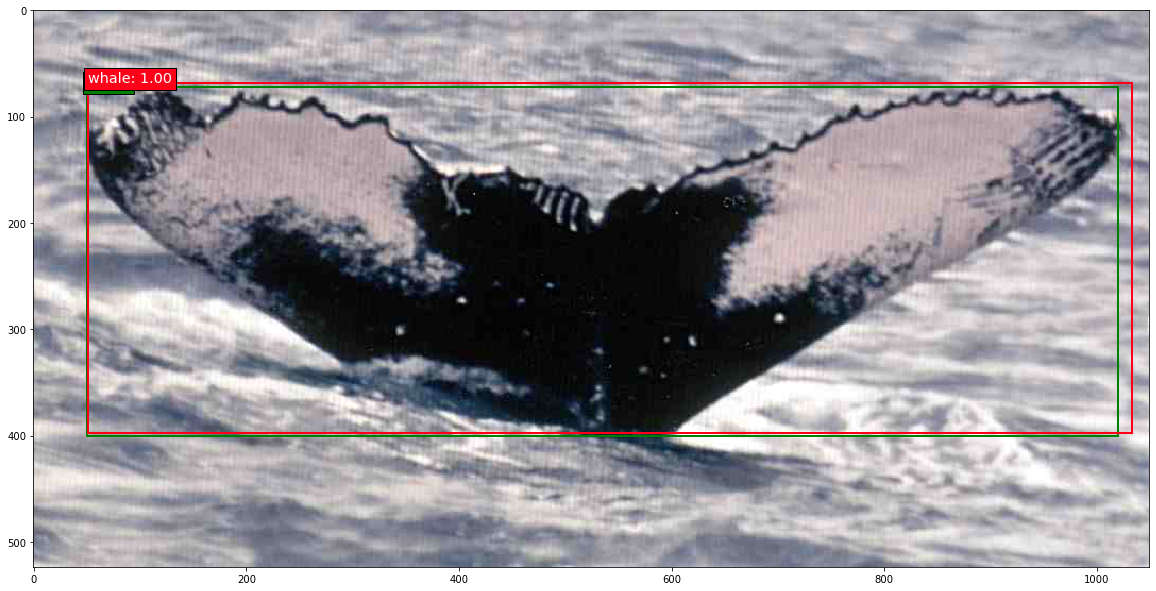

In [22]:
# Mostramos el cuadro predecido en la imagen

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','whale']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    

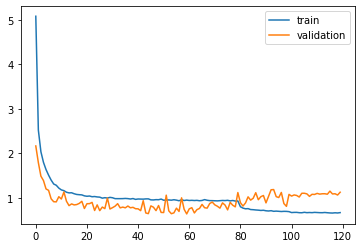

In [23]:
# imprimimos las curvas de pérdida
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [25]:
model.evaluate_generator(val_generator,steps=ceil(val_dataset_size/batch_size),callbacks=callbacks)


0.8237342834472656

In [26]:
model.save('ssd300_whales_epoch-120.h5')